# Lab 1: Serving a Model with vLLM

## Introduction 

This section is to walk through how to serve a open source model using vLLM (the upstream project of Red Hat AI Inference Server.

### What is an Model Server?
A model server is like an operating system for large language model. It is the piece of software that allows artificial intelligence (AI) applications to communicate with large language models (LLMs) and generate a response based on data. When you interact with a model via its API it is called **inferencing.** Inferencing where the business value happens and the end result is delivered.

### How does Red Hat AI Inference Server work?
Red Hat AI Inference Server provides fast and cost-effective inference at scale. Its open source nature allows it to support any generative AI (gen AI) model, on any AI accelerator, in any cloud environment. 

Powered by [vLLM](https://docs.vllm.ai/en/latest/), the inference server maximizes GPU utilization, and enables faster response times. Combined with LLM Compressor capabilities, inference efficiency increases without sacrificing performance. With cross-platform adaptability and a growing community of contributors, vLLM is emerging as the Linux® of gen AI inference. 

### Where can you get different models?
The most popular source of large language models is Hugging Face. Higging Face has contributions from a broad community of orgaisations, researchers, and day-to-day hobbiests. One challenge with the models on Hugging Face is that you cannot always be certain of the provinance of the models - which is a risk for many organisations.

The Red Hat AI repository on Hugging Face provides a trusted and curated set of models and supporting artifacts. We are committed to making AI more accessible, efficient, and community-driven from research to production.

We believe the future of AI is open. That’s why we’re sharing our latest models and research on Hugging Face, which are freely available to help researchers, developers, and organizations deploy high-performance AI at scale.

Here's the link to Red Hat AI Repository - https://huggingface.co/RedHatAI

Let's get going...

# Prepare the workbench
In this exercise you will be folling steps in this notebook as well as using the terminal. In this first step we will adjust the Workbench so you can see both this notebook and the terminal window.

To open a new terminal window:  
1. Click **File > New > Terminal** in the JupyterLab toolbar.
   JupyterLab opens a new tab with a bash terminal session.

2. Click the terminal's tab and drag it to the right side of the screen.
   JupyterLab docks the terminal to the right of this notebook.


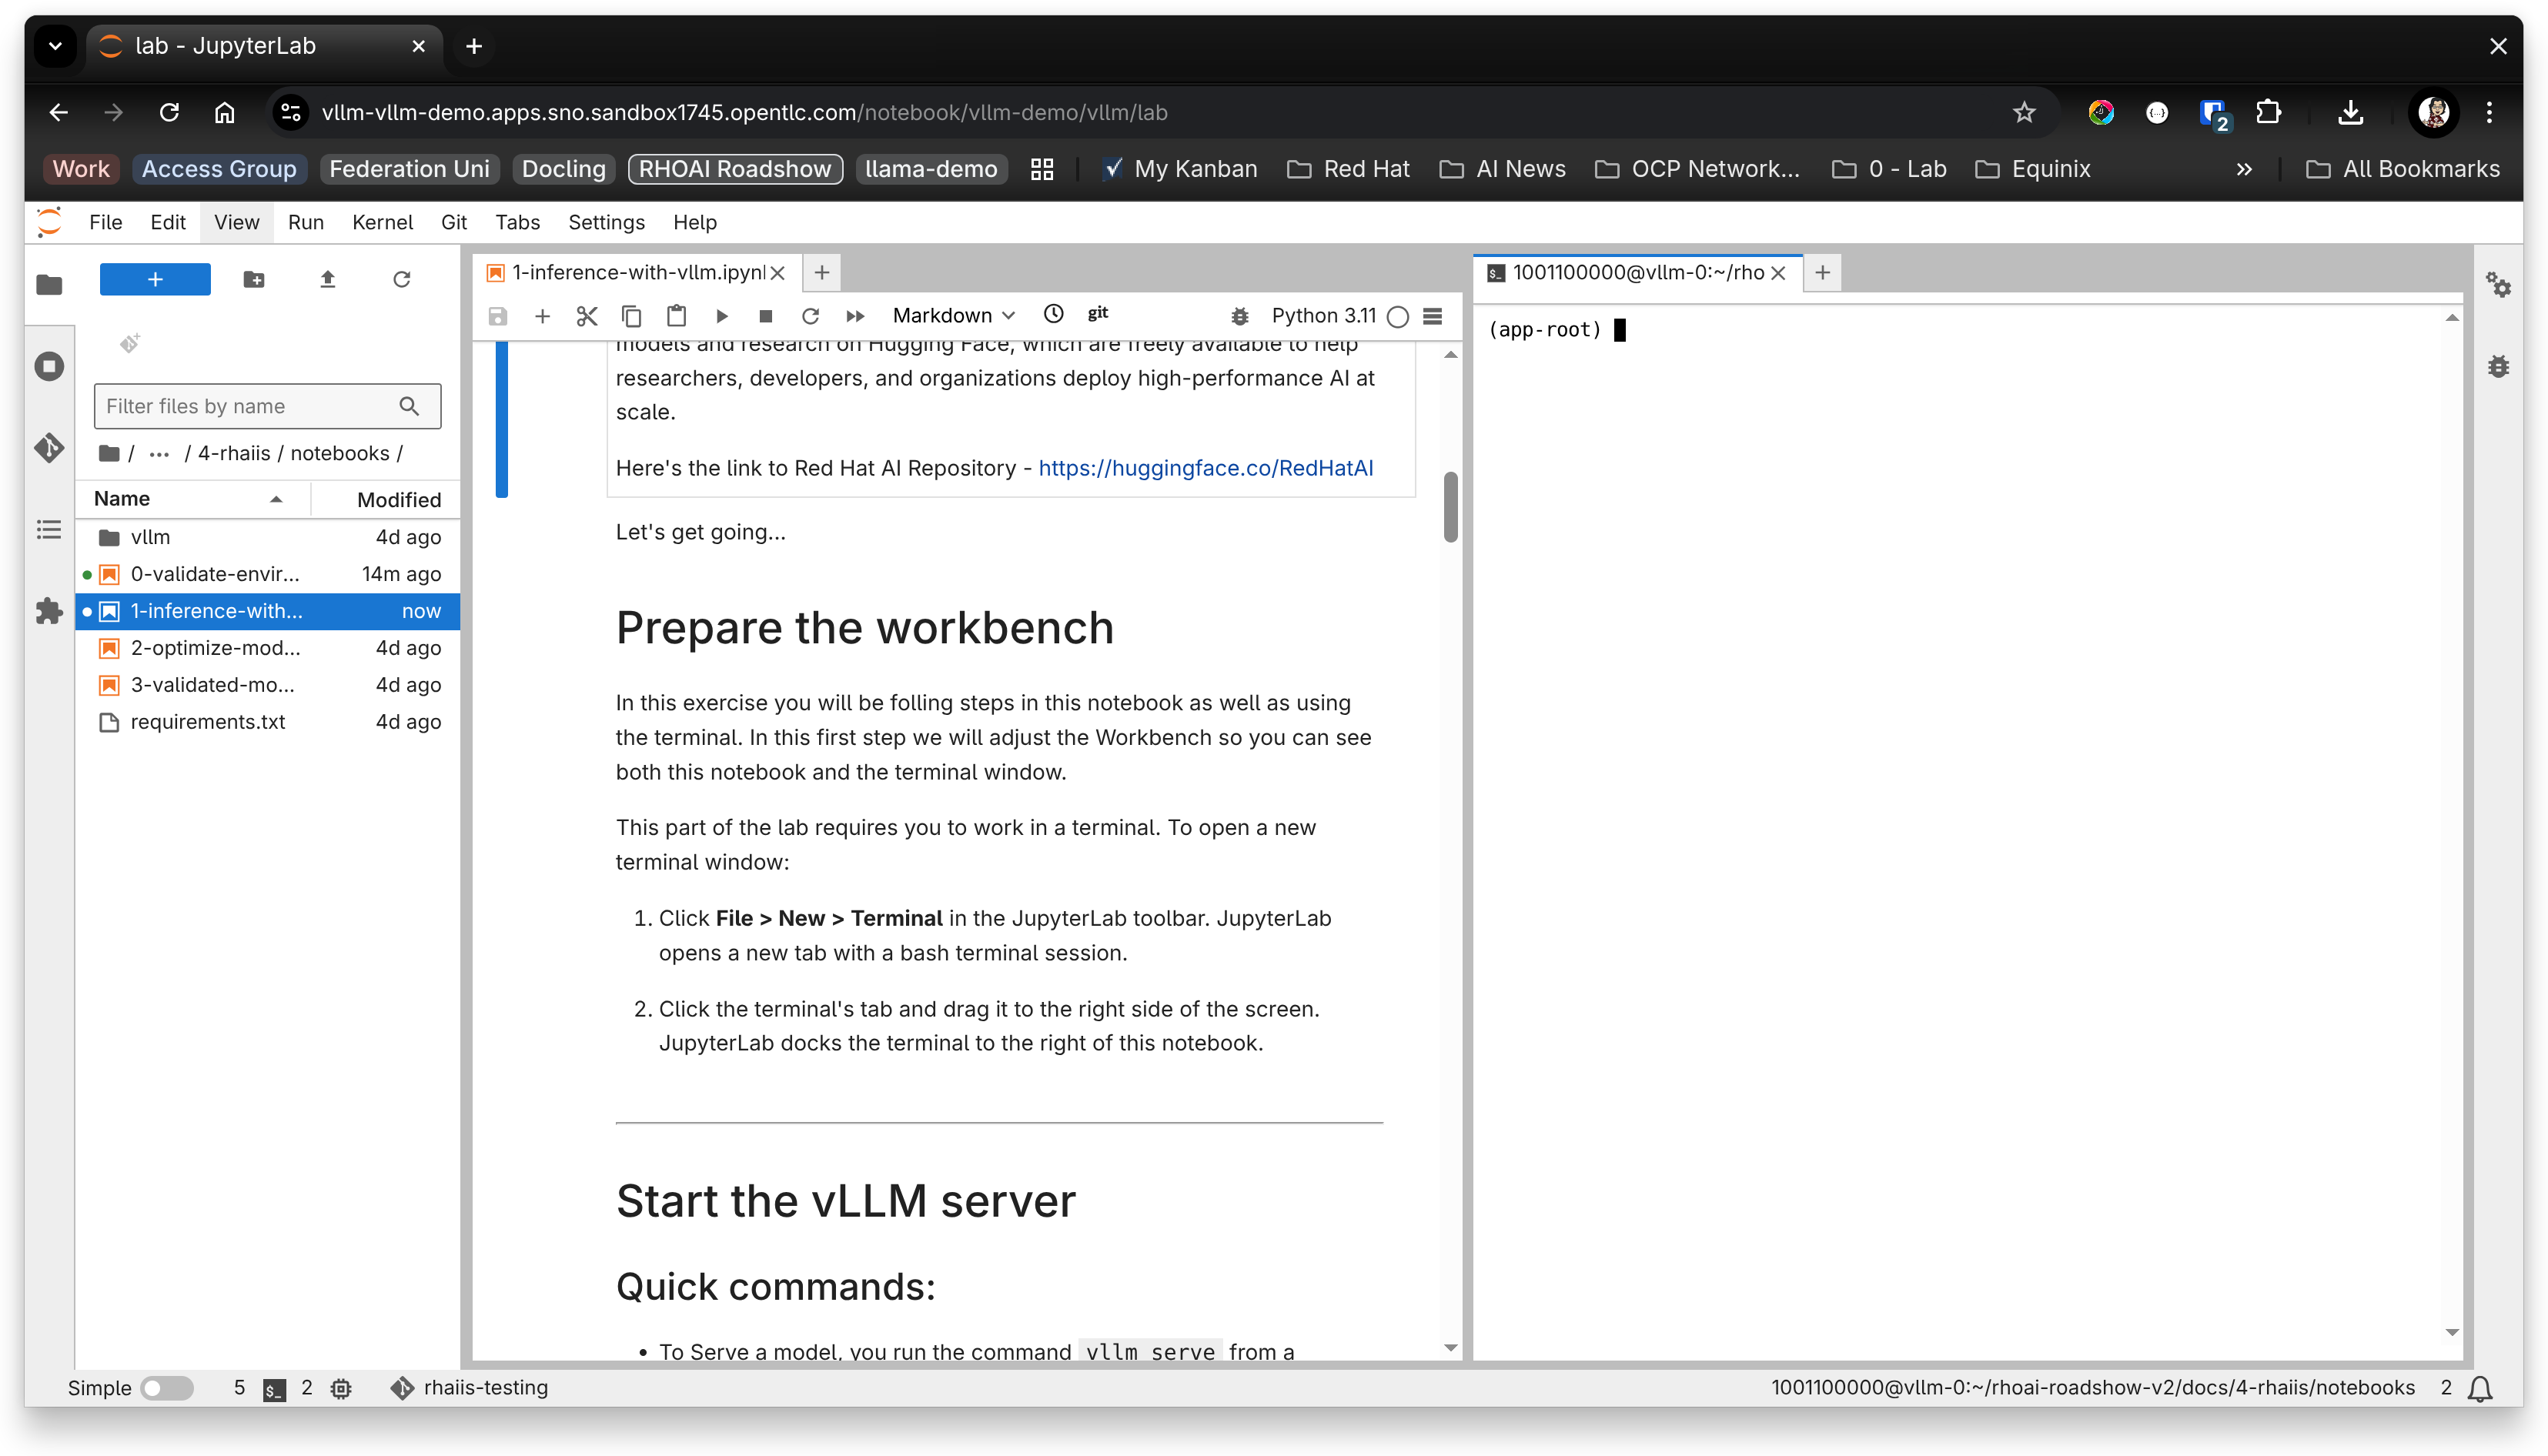

---
# Start the vLLM server

For this lab we will serve the validated model `Llama-3.2-1B-Instruct-FP8` from Red Hat AI Repository on Hugging Face. To view the model details open a new browser tab and paste the following url into the address: `https://huggingface.co/RedHatAI/Llama-3.2-1B-Instruct-FP8.

**Quick Commands for reference:**
* To Serve a model, you run the command `vllm serve` from a terminal.  
* To view all of the vLLM the options type the following into a terminal: `vllm serve -h`.


## Serve the model

3. Highlight the following text:
```
   vllm serve RedHatAI/Llama-3.2-1B-Instruct-FP8 --port 8000 --tensor-parallel-size 1  
```
4. With the text highlightd, type **Ctrl+C** to copy the command to the clipboard.
5. In the Terminal window, right-click.
   JupyterLab displays the copy/paste popup menu.

6. Click **Paste**.
   The command is pasted into the terminal window. Validate it is correct and make ay necessary corrections.

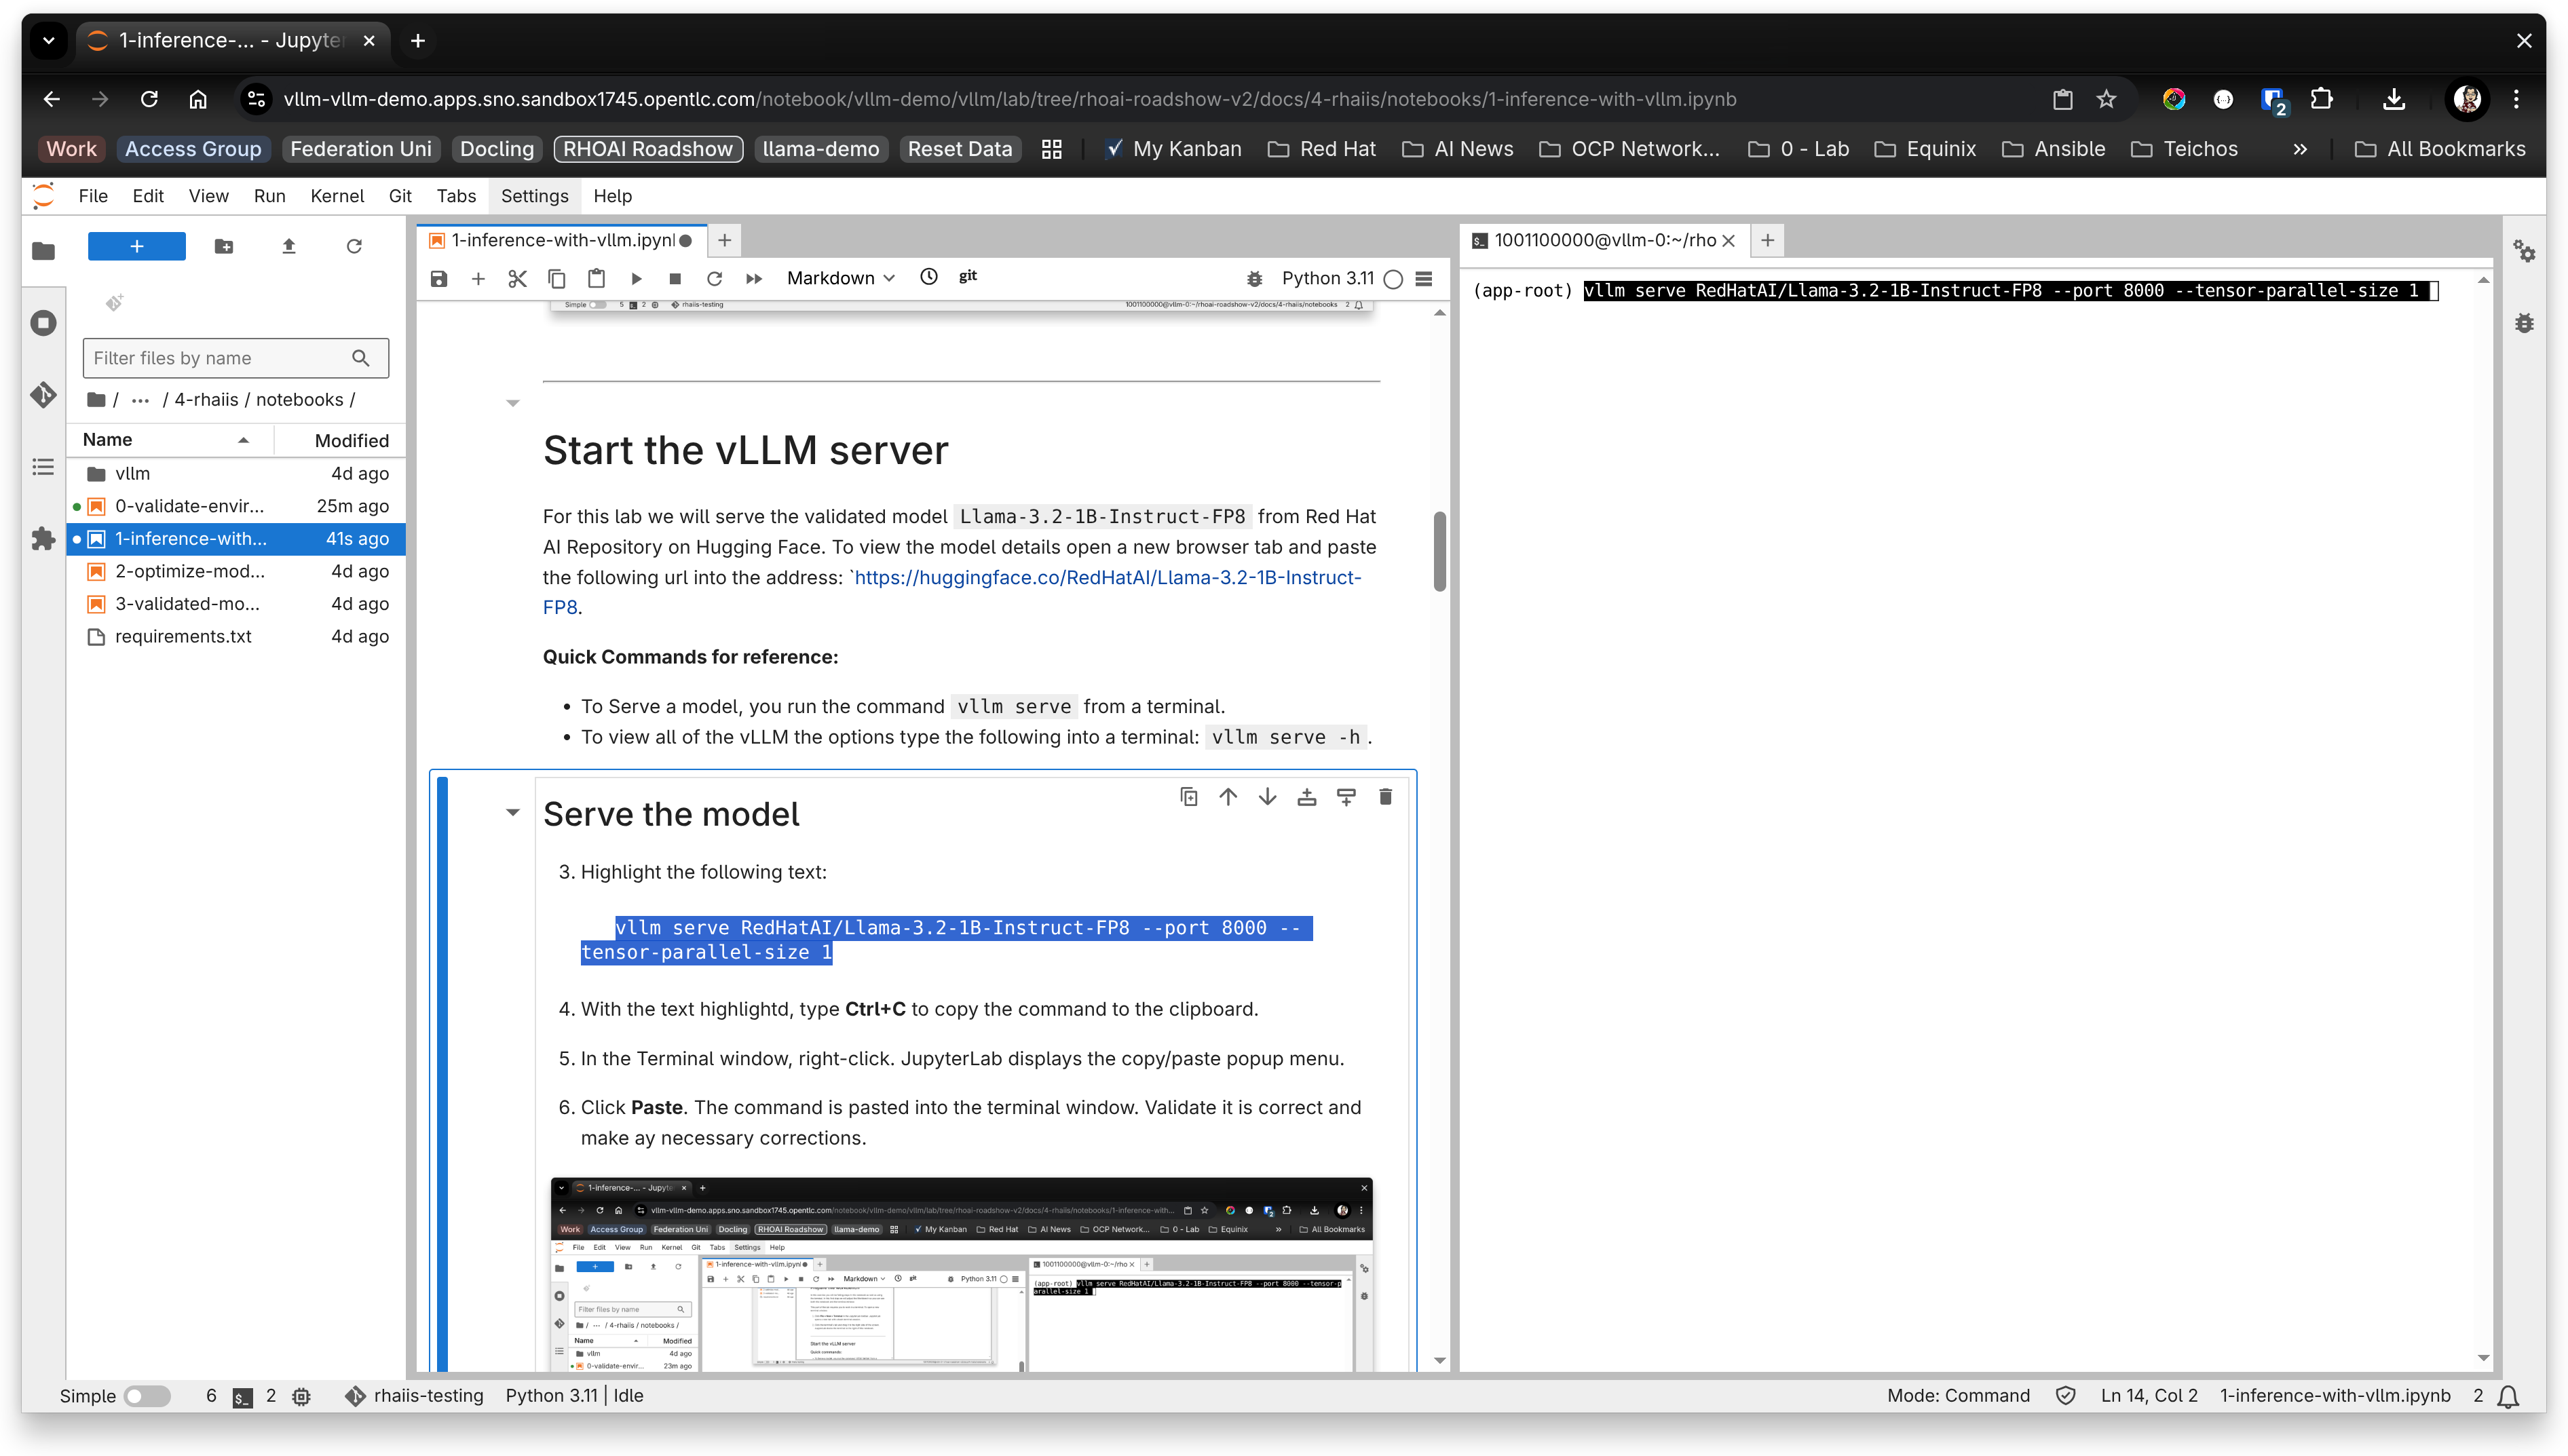
   
7. Press **Enter**.  
   Wait until the following message is displayed before proceeding to the next step:  
   ```
   "INFO:     Application startup complete."
   ```  
   


Once the model is serving successfully as `Application startup complete`, we can start to infer with it.  

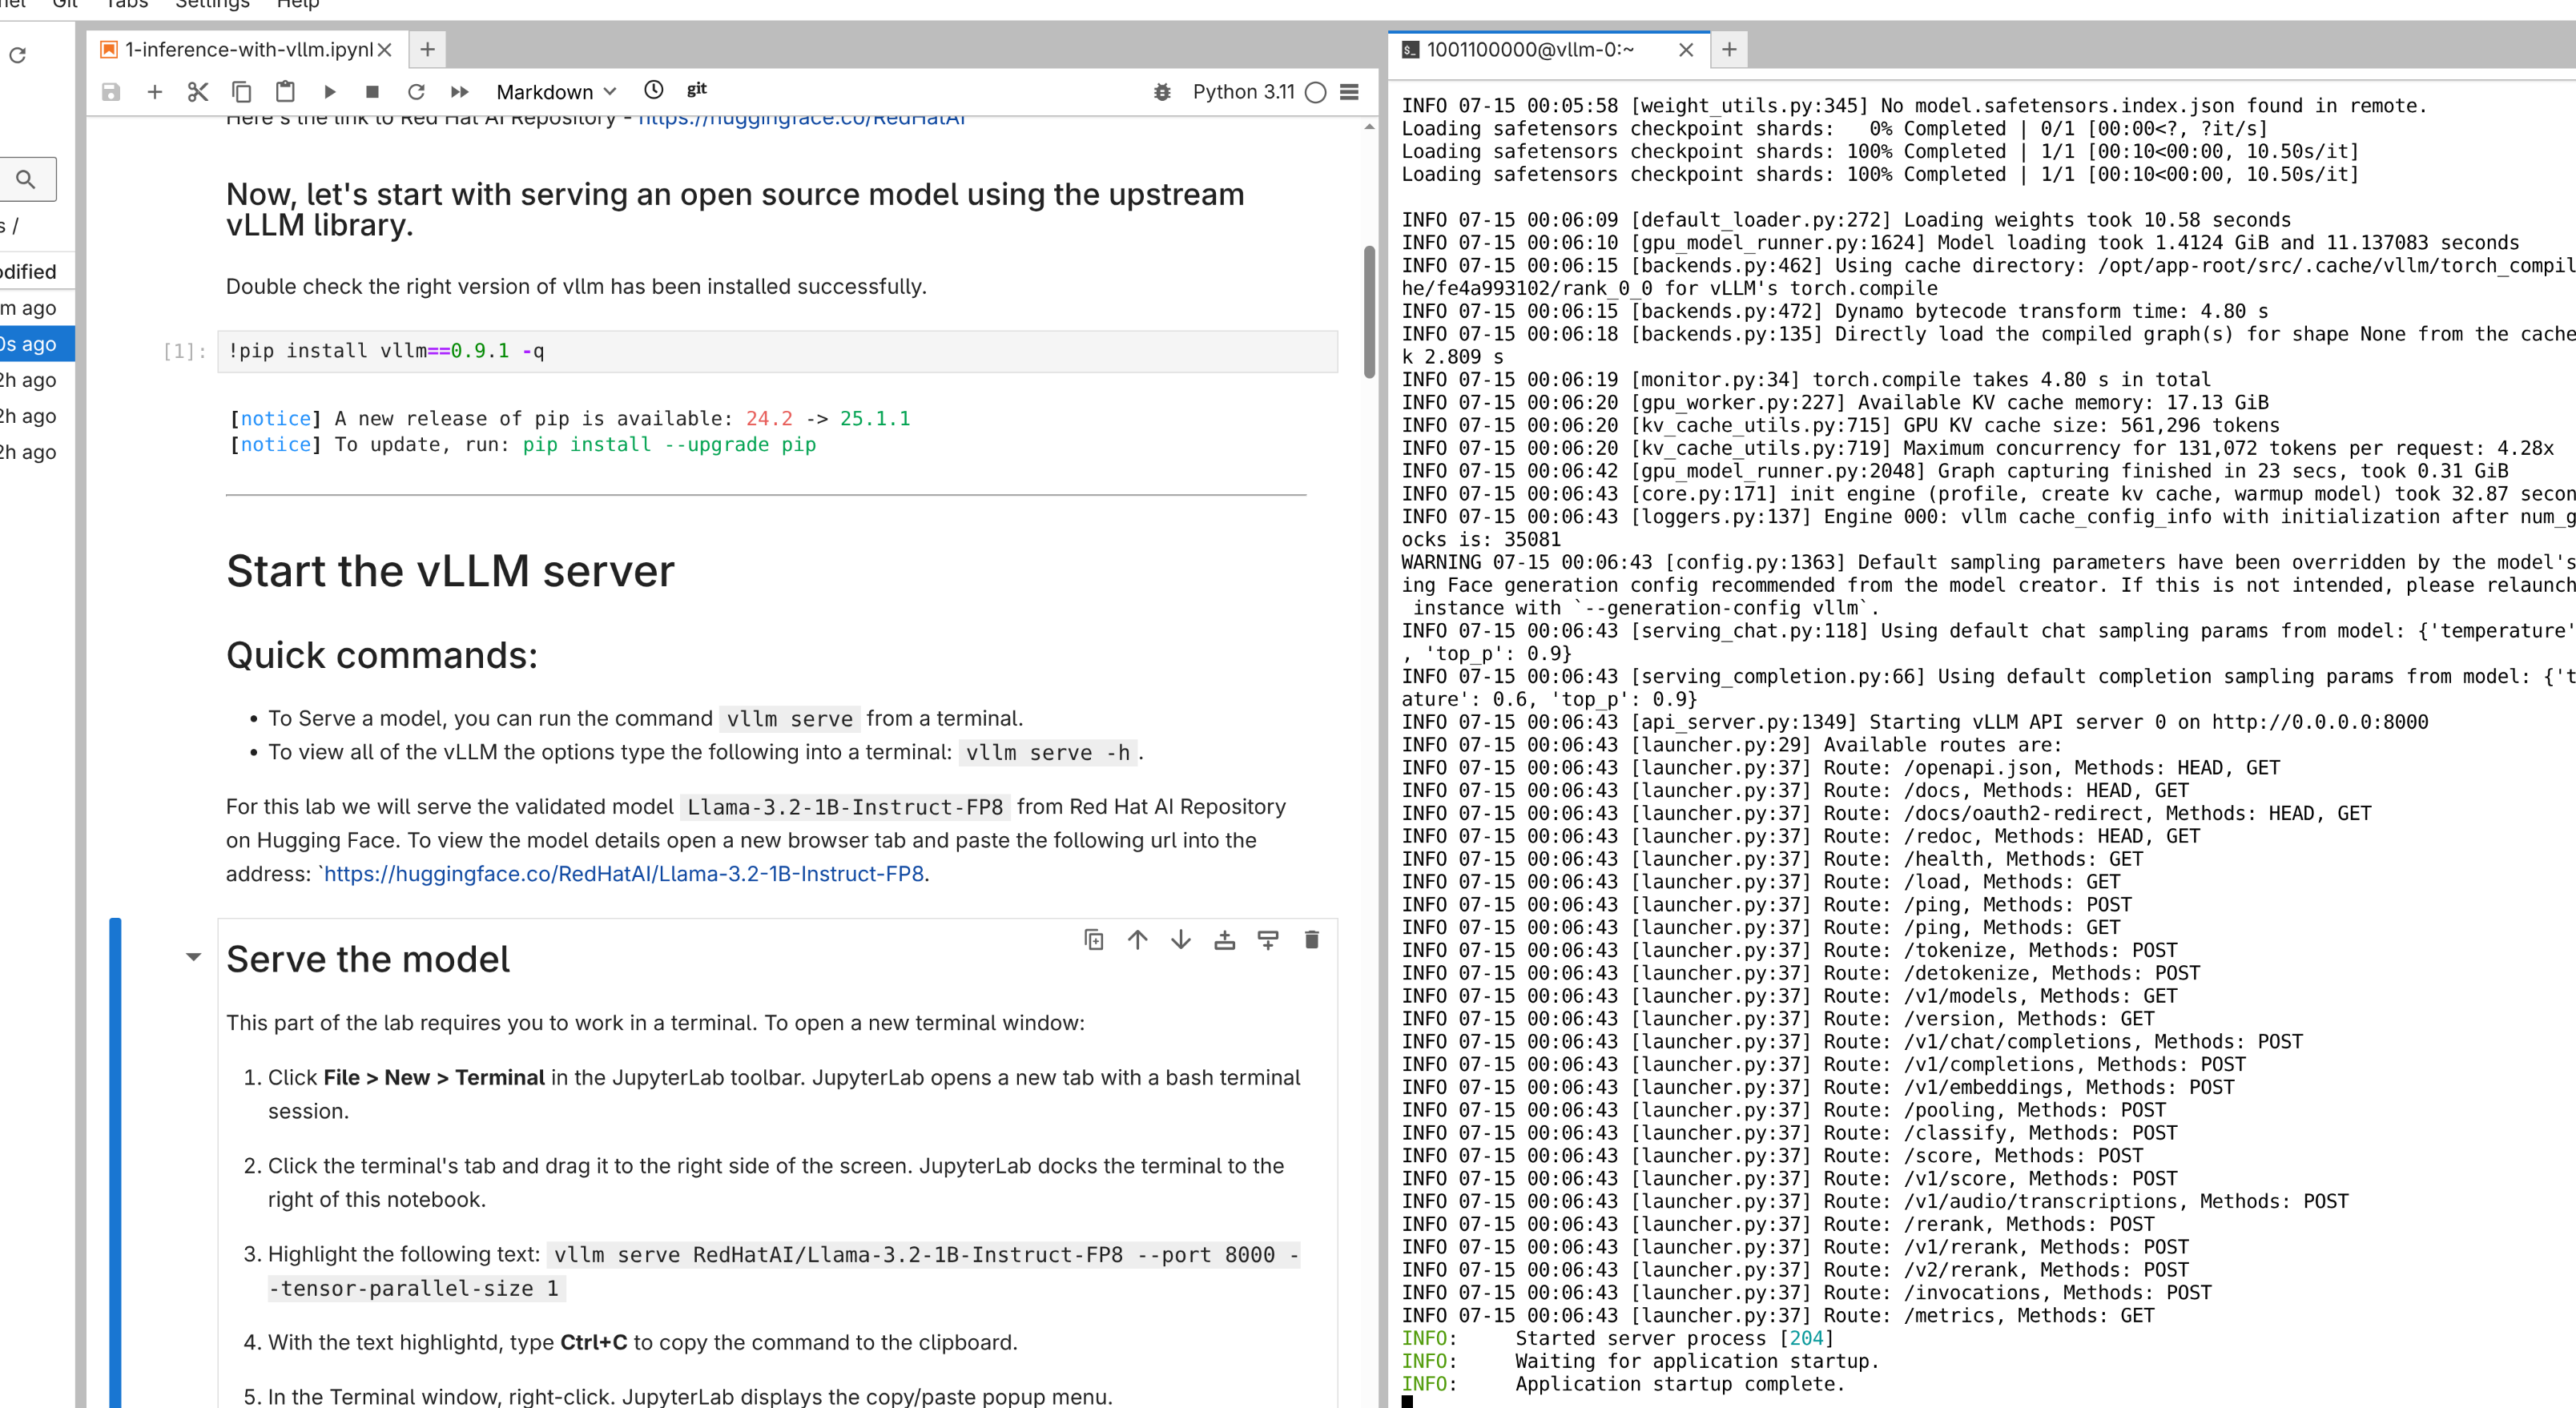

---
### Test that the model is indeed up and running

The model is listening at the following address: `http://localhost:8080`.

Curl is a useful command to interact with HTTP servers. 

The following test will ask the model "What is the capital of France?"

In [ ]:
!curl -X POST -H "Content-Type: application/json" -d '{ \
    "prompt": "What is the capital of France?", \
    "max_tokens": 50 \
}' http://localhost:8000/v1/completions | python -m json.tool

{"id":"cmpl-d40147c50de74ceda1914918168d7467","object":"text_completion","created":1752903749,"model":"RedHatAI/Llama-3.2-1B-Instruct-FP8","choices":[{"index":0,"text":" Paris.\nThe capital of France is indeed Paris. It is the most famous city in France and is known for its iconic landmarks such as the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum.\n\nParis is a city that has","logprobs":null,"finish_reason":"length","stop_reason":null,"prompt_logprobs":null}],"usage":{"prompt_tokens":8,"total_tokens":58,"completion_tokens":50,"prompt_tokens_details":null},"kv_transfer_params":null}

### Observations
The response to the question indicates the model is running.  
The interactions with the model are logged in the terminal window.

# Evaluating a Model
## Model serving key metrics

The following metrics are commonly used to evaluate the performance of the LLM model being served with AI Inference Server:

- ***Time to first token (TTFT)***: How long does it take for the model to provide the first token of its response?
- ***Time per output token (TPOT)***: How long does it take for the model to provide an output token to each user, who has sent a request?
- ***Latency***: How long does it take for the model to generate a complete response?
- ***Throughput***: How many output tokens can a model produce simultaneously, across all users and requests?

## Benchmark the model
In this next section you will use a benchmark test agaist the model we are running in vLLM.  

### Download the benchmarking tool

In [2]:
!git clone https://github.com/vllm-project/vllm.git

fatal: destination path 'vllm' already exists and is not an empty directory.


In [ ]:
!cd vllm && git checkout v0.9.1

With the vllm tools downloaded, you will run the run the performance-benchmark tool.

**Note:** You may need to use Huggingface Token to run the following step. If you experience an error please consult with your instructor to set up your hugging face token using one of the following methods:\
`!export HF_TOKEN=hf_xxxx` \
Or, use `huggingface-cli login`

In [ ]:
%env HF_TOKEN=hf_xxxx

In [3]:
!python vllm/benchmarks/benchmark_serving.py \
--backend vllm --model RedHatAI/Llama-3.2-1B-Instruct-FP8 \
--num-prompts 100 --dataset-name random  --random-input 200 --random-output 200 --port 8000

INFO 07-19 05:42:35 [__init__.py:244] Automatically detected platform cuda.
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, no_stream=False, max_concurrency=None, model='RedHatAI/Llama-3.2-1B-Instruct-FP8', tokenizer=None, use_beam_search=False, num_prompts=100, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=False, percentile_metrics='ttft,tpot,itl', metric_percentiles='99', goodput=None, custom_output_len=256, custom_skip_chat_template=False, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=200, random_output_len=200, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p

---
vLLM is a very fast model server. Observe the results above and compare them to the benchmark results published for the NVIDIA NIM serving benchmark. Source:  https://docs.nvidia.com/nim/benchmarking/llm/latest/performance.html#llama-3-1-8b-instruct-results.

In [4]:
from IPython.display import IFrame

IFrame("https://docs.nvidia.com/nim/benchmarking/llm/latest/performance.html#llama-3-1-8b-instruct-results", width=600, height=600)

---
### Explaining the performance benchmark

In the next section you will illustrate how the vLLM model server enables you to run the same model with a fraction of the GPU resources of other model servers.

1. Validate that an NVIDIA L4 GPU is being used in this lab. To do that you will need to inspect the details of the Pod running the vLLM server.

In [5]:
!oc login -u admin -p ${ADMIN_PASSWORD} --server=https://api.sno.${BASE_DOMAIN}:6443

Login successful.

You have access to 109 projects, the list has been suppressed. You can list all projects with 'oc projects'

Using project "vllm-demo".


2. List all the pods and find the name of the pod that our workbench is running.

In [6]:
!oc project vllm-demo
!oc get pods

Already on project "vllm-demo" on server "https://api.sno.sandbox1745.opentlc.com:6443".
NAME     READY   STATUS    RESTARTS   AGE
vllm-0   2/2     Running   0          86m


The nvidia-smi utility is is a command-line utility provided by NVIDIA for managing and monitoring NVIDIA GPUs.  

3. Run the `nvidia-smi` utility in the Pod to retrieve the details of the NVIDIA GPU

In [7]:
!oc exec vllm-0 -- nvidia-smi

Defaulted container "vllm" out of: vllm, oauth-proxy
Sat Jul 19 05:42:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:36:00.0 Off |                    0 |
| N/A   45C    P0             36W /   72W |   20888MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N

Observe that the reported GPU is a **shared L4 GPU** with only **24GB** memory.

4. Compare the results with Nvidia NIM benchamark test.  

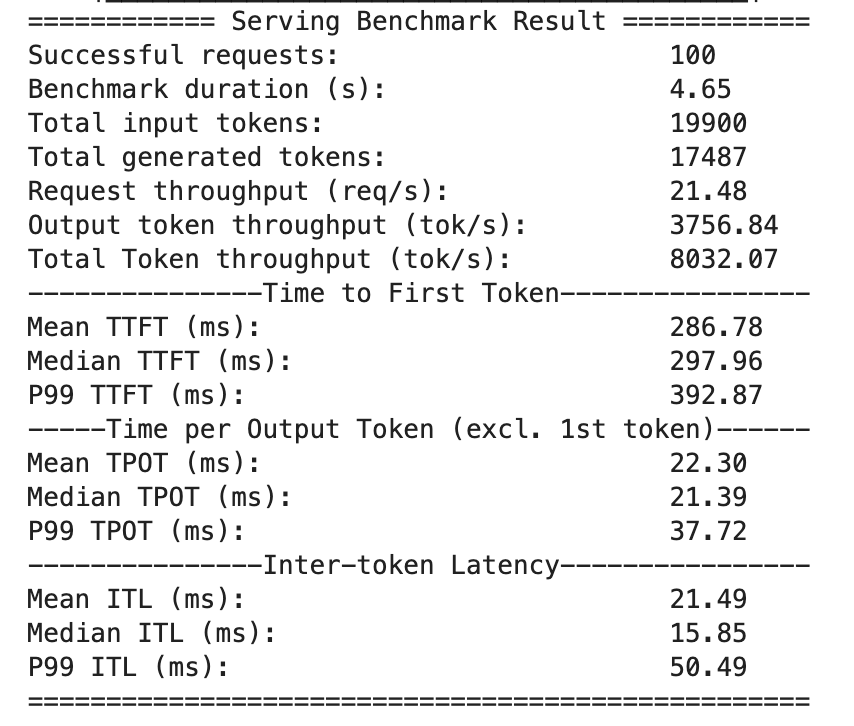

Observe the following highlights of vllm's performance data:

|   Metrics             |   vLLM with L4 GPU |   NIM with H100 GPU  |
|-----------------------|--------------------|----------------------|
| GPU Memory            |        24 GiB      |        80 GiB        |
| FP16                  |      ~120 TFLops   |      ~500-700 TFlops |
| INT8                  |      ~240 Tops     |       ~2000 Tops     |
| Mem. Bandwidth        |       300 GB/s     |     Up to 3.35 TB/s  |
|-----------------------|--------------------|----------------------|
| Mean TTFT (S)         |        0.29        |         0.12         |
| Mean ITL (S)          |        0.22        |         0.07         |
| Throughput (tokens/s) |       8,032.07      |      12,214.97        |
|-----------------------|--------------------|----------------------|
| Approx. Unit Price($) |        2,000       |       25,000         |

Observe that in this lab you are using ***~10x*** cheaper GPU and vLLM serving a similar size of the LLama3.2 model.  

This represents nearly a **50%** increase in performance.

---
## 📌  Shut down the model server📌 

In the terminal window, type **Ctrl+C** to shut down the model server.

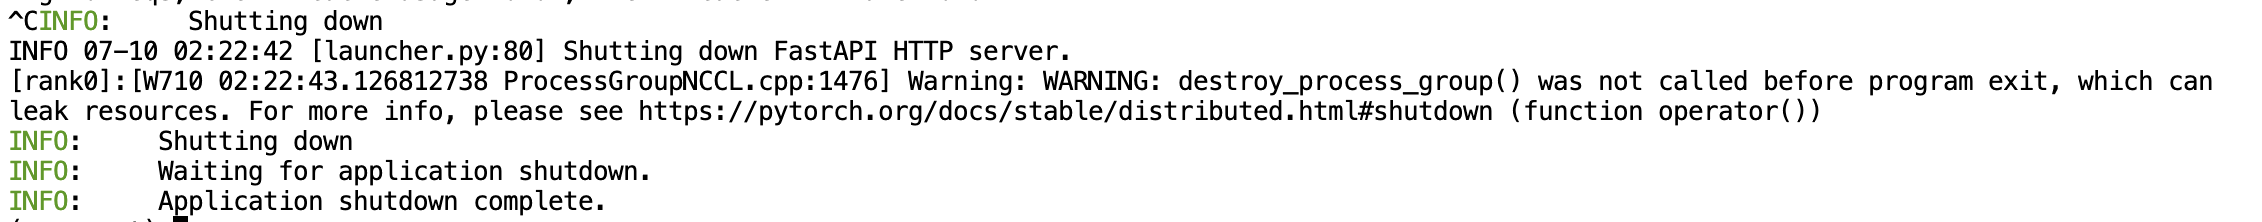

---
This is the end of Lab 1 - Serving a model with vLLM.